In [ ]:
! pip install visionts

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import einops

from huggingface_hub import snapshot_download
import os
# from eval_gluonts import dataset

# run `pip install visionts` in advance to install the package
from visionts import VisionTS, freq_to_seasonality_list, VisionTSpp

## Load VisionTS++ model

In [2]:
# HuggingFace repo_id
repo_id = "Lefei/VisionTSpp"

# local directory to save the VisionTS++ model, you can change it to any directory you want
local_dir = "./hf_models/VisionTSpp"

In [ ]:
# download the model
# If network is slow, you can try download directly from the huggingface repository!
snapshot_download(
    repo_id=repo_id,
    local_dir=local_dir,
    local_dir_use_symlinks=False
)

Note: You should choose either "base" or "large" for model size of VisionTS++ !!!

In [3]:
# ! IMPORTANT: You should choose either "base" or "large" for model size !!!

MODEL_SIZE = "base"
# MODEL_SIZE = "large"

In [ ]:
if MODEL_SIZE == "base":
    ARCH = 'mae_base'
    ckpt_path = os.path.join(local_dir, "visiontspp_base.ckpt")
else:
    ARCH = 'mae_large'
    ckpt_path = os.path.join(local_dir, "visiontspp_large.ckpt")

if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Checkpoint file not found: {ckpt_path}")


DEVICE = 'cuda:0'

# ===== Load the model =====
model = VisionTSpp(
    ARCH,
    ckpt_path=ckpt_path,
    quantile=True,
    clip_input=True,
    complete_no_clip=False,
    color=True
).to(DEVICE)

print(f"Model loaded from {ckpt_path}, with model size: {MODEL_SIZE}")

Load ./hf_models/VisionTSpp/visiontspp_base.ckpt
Model loaded from ./hf_models/VisionTSpp/visiontspp_base.ckpt, with model size: base


In [ ]:
# model

## Define util functions

In [5]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

FIGURES_DIR = './figures_demo/'


def show_image(image, title='', cur_nvars=1, cur_color_list=None):
    # image is [H, W, 3]
    
    # handle the color channels of the image according to the color_list
    cur_image = torch.zeros_like(image)
    cur_image = cur_image.cpu()
    
    height_per_var = image.shape[0] // cur_nvars
    for i in range(cur_nvars):
        cur_color = cur_color_list[i]
        cur_image[i*height_per_var:(i+1)*height_per_var, :, cur_color] = \
            (image[i*height_per_var:(i+1)*height_per_var, :, cur_color].cpu() * imagenet_std[cur_color] + imagenet_mean[cur_color]) * 255
    cur_image = torch.clip(cur_image, 0, 255).int()
    
    plt.imshow(cur_image)
    plt.title(title, fontsize=16)
    plt.axis('off')


FONT_LEGEND = 8
def run(x, y, periodicity, nvars=1, color_list=None):
    # input shape: [n_batch, context_len, n_vars]
    # output shape: [n_batch, pred_len, n_vars]
    x = torch.Tensor(einops.rearrange(x, 't m -> 1 t m')).to(DEVICE)
    y = torch.Tensor(einops.rearrange(y, 't m -> 1 t m')).to(DEVICE)
    
    # Before calling forward, make sure you use update_config() to update hyperparameters, context length or prediction length.
    model.update_config(context_len=x.shape[1], pred_len=y.shape[1], periodicity=periodicity, 
                        num_patch_input=7, padding_mode='constant')
    
    # Forecasting time series
    with torch.no_grad():
        y_pred, input_image, reconstructed_image, nvars_output, color_list_output = model.forward(x, export_image=True, color_list=color_list)

    # model returns a list, which contains the median predicted values and the corresponding quantile predictions
    y_pred, y_pred_quantile_list = y_pred

    
    # Visualization
    plt.subplot(2, 2, 1)
    show_image(input_image[0, 0], f'input {nvars} vars', nvars, color_list)

    plt.subplot(2, 2, 2)
    plt.plot(x.cpu()[0, :, 0])
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y.cpu()[0, :, 0], label='true', alpha=0.5)
    plt.title('input time series 1st variate')
    plt.legend()
    plt.tight_layout()

    plt.subplot(2, 2, 3)
    show_image(reconstructed_image[0, 0], 'reconstructed', nvars, color_list)

    plt.subplot(2, 2, 4)
    plt.plot(x.cpu()[0, :, 0])
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y.cpu()[0, :, 0], label='true', alpha=0.5)
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y_pred.cpu()[0, :, 0], label='pred')
    
    if y_pred_quantile_list is not None:
        for j, y_pred_quantile in enumerate(y_pred_quantile_list):
            if j < len(y_pred_quantile_list) // 2:
                plt.plot(torch.arange(y.shape[1]) + x.shape[1], y_pred_quantile.cpu()[0, :, 0], label=f'pred_0.{j+1}', color=f'C{j+2}', alpha=0.5)
            else:
                plt.plot(torch.arange(y.shape[1]) + x.shape[1], y_pred_quantile.cpu()[0, :, 0], label=f'pred_0.{j+2}', color=f'C{j+2}', alpha=0.5)
    
    plt.title(f'ctx={x.shape[1]}, pred={y.shape[1]}, period={periodicity}')
    plt.legend(fontsize=FONT_LEGEND)
    plt.tight_layout()
    plt.show()


    FIG_WIDTH = 17.5
    FIG_HEIGHT_PER_VAR = 1.5
    FONT_S = 13
    FONT_L = 15
    IM_ALPHA = 0.8
    def visual_ts(true, preds=None, name='prediction.pdf', lookback_len_visual=300, pred_len=100):
        nvars = true.shape[1]
        
        # change to numpy array
        if not isinstance(true, np.ndarray):
            true = true.cpu().numpy()
        if preds is not None and not isinstance(preds, np.ndarray):
            preds = preds.cpu().numpy()
        
        # Create a figure with `nvars=7` rows and 1 column, and set the height ratio of each row to 1.
        fig, axes = plt.subplots(nrows=nvars, ncols=1, figsize=(FIG_WIDTH, nvars * FIG_HEIGHT_PER_VAR), sharex=True,
                                    gridspec_kw={'height_ratios': [1] * nvars})
        
        # remove the vertical space between subplots
        plt.subplots_adjust(hspace=0)
        
        # cut the lookback-window for visualization
        true = true[-lookback_len_visual - pred_len:]
        if preds is not None:
            preds = preds[-lookback_len_visual - pred_len:]
        
        # iterate each variable
        for i, ax in enumerate(axes):
            # ground-truth values
            ax.plot(true[:, i], label='GroundTruth', color='gray', linewidth=1.5)
            
            # prediction values
            if preds is not None:
                # only visualize the prediction within the lookback-window
                ax.plot(np.arange(lookback_len_visual, len(true)), preds[lookback_len_visual:, i], label='Prediction_0.5', color='blue', linewidth=1.5)
            
            # add a vertical line to separate the lookback-window and prediction
            y_min, y_max = ax.get_ylim()
            ax.vlines(x=lookback_len_visual, 
                    ymin=y_min, 
                    ymax=y_max, 
                    linewidth=1, 
                    linestyles='dashed', 
                    colors='gray')
            
            # remove the x-axis and y-axis ticks and labels
            ax.tick_params(axis='x', which='both', length=0)
            ax.tick_params(axis='y', which='both', length=0)
            ax.set_xticks([])
            ax.set_yticks([])
            
            # add a text label to the top-left corner of the subplot
            ax.text(0.007, 0.8, f'Var {i+1}', transform=ax.transAxes, fontsize=FONT_S)
        
        # Add the legend to the first subplot
        if preds is not None:
            handles, labels = axes[0].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.9, 0.935), prop={'size': FONT_S-2})
        
        # Calculate MSE & MAE, and add it to the figure title.
        if preds is not None:
            preds_calc = preds[-pred_len:]
            true_calc = true[-pred_len:]
            mse = np.mean((preds_calc - true_calc) ** 2)
            mae = np.mean(np.abs(preds_calc - true_calc))
            fig.suptitle(f'MSE: {mse:.3f}, MAE: {mae:.3f}', fontsize=FONT_L, y=0.915)
        
        plt.savefig(name, bbox_inches='tight', dpi=300)
        plt.show()

    
    # y[0].shape: [context_len, n_vars]
    # y_pred[0].shape: [pred_len, n_vars]
    cur_gt = np.concatenate([x[0].cpu().numpy(), y[0].cpu().numpy()], axis=0)
    cur_pred = np.concatenate([x[0].cpu().numpy(), y_pred[0].cpu().numpy()], axis=0)

    visual_ts(true=cur_gt, preds=cur_pred, 
              name=FIGURES_DIR+'prediction.pdf', lookback_len_visual=x.shape[1], pred_len=y.shape[1])
    

    # Save the figures
    def save_image(image, title='', cur_nvars=1, cur_color_list=None, save_path='image.pdf'):
        # image is [H, W, 3]
        
        # handle the color channels of the image according to the color_list
        cur_image = torch.zeros_like(image)
        cur_image = cur_image.cpu()
        
        height_per_var = image.shape[0] // cur_nvars
        for i in range(cur_nvars):
            cur_color = cur_color_list[i]
            cur_image[i*height_per_var:(i+1)*height_per_var, :, cur_color] = \
                (image[i*height_per_var:(i+1)*height_per_var, :, cur_color].cpu() * imagenet_std[cur_color] + imagenet_mean[cur_color]) * 255
        cur_image = torch.clip(cur_image, 0, 255).int()
        
        plt.plot(figsize=(10, 10))
        plt.imshow(cur_image)
        plt.title(title, fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
        # plt.show()
    
    save_image(input_image[0, 0], 'input', nvars, color_list, save_path=FIGURES_DIR+'input.pdf')
    save_image(reconstructed_image[0, 0], 'reconstructed', nvars, color_list, save_path=FIGURES_DIR+'reconstructed.pdf')
    

## Zero-Shot Forecasting

- Example 1: a multivariate time series dataset ETTm1. 
    - Since ETTm1 is not included in the pre-trained datasets of VisionTS++, this is a zero-shot forecasting task.

ATTENTION: If you have problems downloading the ETTm1 dataset through the following code, you can also download it from [Google Drive](https://drive.google.com/drive/folders/13Cg1KYOlzM5C7K8gK8NfC-F3EYxkM3D2?usp=sharing) or [Baidu Netdisk](https://pan.baidu.com/s/1r3KhGd0Q9PJIUZdfEYoymg?pwd=i9iy), from [Time-Series-Library](https://github.com/thuml/Time-Series-Library?tab=readme-ov-file).

In this demo, we use the last window of ETTm1 dataset for inference.

In [6]:
import pandas as pd
import numpy as np
import os

# ===== Load ETTm1 data =====
if not os.path.exists("./datasets"):
    os.makedirs("./datasets")

# The path of the ETTm1 data file
data_path = "./datasets/ETTm1.csv"

# ATTENTION: If you have problems downloading the ETTm1 dataset through the following code, 
# you can also download it from [Google Drive](https://drive.google.com/drive/folders/13Cg1KYOlzM5C7K8gK8NfC-F3EYxkM3D2?usp=sharing) 
# or [Baidu Netdisk](https://pan.baidu.com/s/1r3KhGd0Q9PJIUZdfEYoymg?pwd=i9iy).
# The data link is from [Time-Series-Library](https://github.com/thuml/Time-Series-Library?tab=readme-ov-file).
if not os.path.exists(data_path):
    print("Downloading ETTm1.csv...")
    
    url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv"
    df = pd.read_csv(url)
    df.to_csv(data_path, index=False)
else:
    df = pd.read_csv(data_path)

# transform the date column to datetime format
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
print(f"{df.shape = }")

cols = df.columns[:]
data = df[cols].values  # shape: [T, num_vars]

print(f"Loaded ETTm1 data with shape: {data.shape}")


# ===== Normalize the input data =====
training_len = int(len(data) * 0.7)  # 70% of data for training
x_training = data[:training_len, :]
x_mean = x_training.mean(axis=0, keepdims=True)
x_std = x_training.std(axis=0, keepdims=True)
print(f"x_mean.shape = {x_mean.shape}, x_std.shape = {x_std.shape}")

data_normalized = (data - x_mean) / x_std
print(f"data_normalized shape = {data_normalized.shape}")


# ===== Create inference windows =====
def create_inference_windows(data, in_len=96, out_len=24):
    """
    Generate x (input) and y (output) for inference.
    Only the last window is used for inference.
    """
    T = len(data)
    assert T >= in_len + out_len, "Too short data for inference"

    # we randomly select the last window for inference
    end_idx = T
    start_idx = end_idx - (in_len + out_len)

    x = data[start_idx:start_idx + in_len]  # input segment
    y = data[start_idx + in_len:end_idx]    # output segment

    return x, y


# set the input and output length
in_len = 960
out_len = 394

x, y = create_inference_windows(data_normalized, in_len=in_len, out_len=out_len)

print(f"x.shape = {x.shape}, y.shape = {y.shape}")


df.shape = (69680, 7)
Loaded ETTm1 data with shape: (69680, 7)
x_mean.shape = (1, 7), x_std.shape = (1, 7)
data_normalized shape = (69680, 7)
x.shape = (960, 7), y.shape = (394, 7)


## Visualization of predictions

There will be two figures generated from this cell. 

The first figure includes the transformeed image, the reconstruction image; the original time series (first variate and last window of ETTm1 datasetst), and the predicted time series of quantile level of 10\%, 20\%, ..., 90\%, which flexibly approximates an output distribution for probabilistic forecasting. 

The second figure shows the median prediction (50\%) of 7 variates of ETTm1 dataset, showing VisionTS++'s capability of handling multivariate time series forecasting. 

96


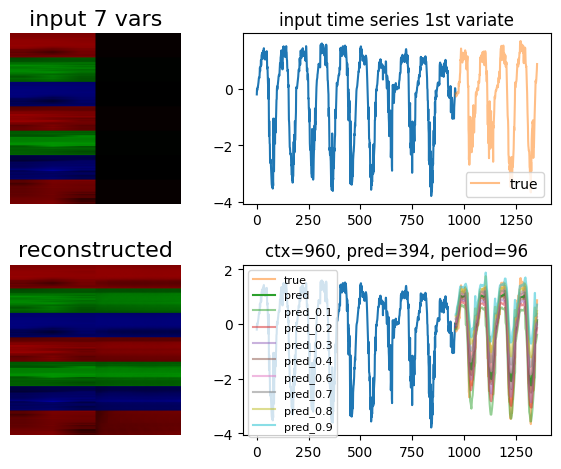

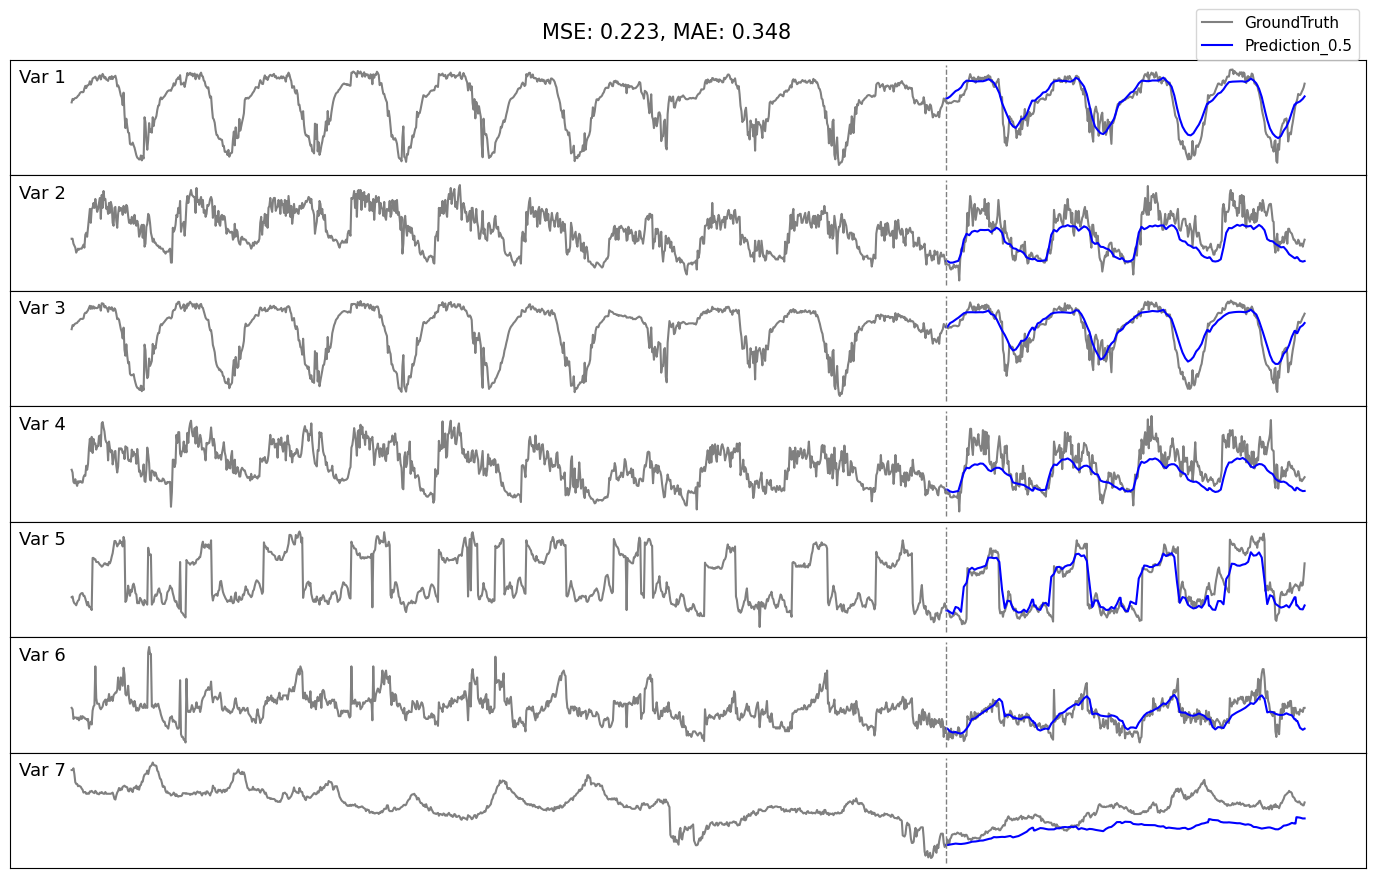

In [7]:
# Since ETTm1 is sampled every 15 minutes, so a possible choice of its periodicity is 96.
periodicity_list = freq_to_seasonality_list("15Min")
periodicity = periodicity_list[0]
print(periodicity)
# expected: periodicity = 96

nvars = x.shape[1]  # 7 variables for ETTm1

# You canr randomly assign colors to each variables
# Our recommendation is to follow a RGB iteration form (R, G, B, R, G, B,...) in order for simplicity.
color_list = [i % 3 for i in range(nvars)]


# run() function accepts raw data
run(x, y, periodicity=periodicity, nvars=nvars, color_list=color_list)

Visualization on more complicated examples can be found in Appendix C of our paper.